# D: Ejercicios Web scraping

***
**Ejercicio D.1:** Obtener un campo del Sloan Digital Sky Survey (SDSS)

El [SDSS](https://www.sdss.org/) tiene multitud de herramientas que permiten la obtención de datos e imágenes del cielo. Por ejemplo en https://dr12.sdss.org/fields/ podemos descargar campos concretos utilizando las coordenadas del cielo que nos interesan. Jugando un poco con el formulario de esa página "descubrimos" que podemos obtener el campo mediante el uso de la siguiente URL que tiene como parámetros la ascension recta (ra) y la declinación (dec):

https://dr12.sdss.org/fields/raDec?ra=250.423475&dec=36.461319

Programemos una función para descargar la imagen que corresponde a cualquier coordenada que nos interese:


In [1]:
import requests
import regex as re

def descargaSDSS(ra, dec, nombreFichero):
    url = f"https://dr12.sdss.org/fields/raDec?ra={ra}&dec={dec}"
    
    respuesta = requests.get(url)
    
    html = respuesta.content.decode("UTF-8")
    
    # print(html)
    
    urlImagen = "https://dr12.sdss.org" + re.search(r'id="jpg" src="(.*?)"', html).group(1)
    
    print(urlImagen)
    

    respuesta = requests.get(urlImagen)   #Descargamos la imagen
    
    myfile = open(nombreFichero,'wb')
    myfile.write(respuesta.content)
    myfile.close()
        
    
    
descargaSDSS(250.423475, 36.461319, "salidas/m13.jpg")

print("Descarga realizada")

https://dr12.sdss.org/sas/dr12/boss/photoObj/frames/301/3226/5/frame-irg-003226-5-0127.jpg
Descarga realizada


***
**Ejecicio D.2:** Astronomy Picture of the Day (APOD) (desde la página oficial)

Queremos hacer un script que descargue la imagen astronómica del día y la ponga de fondo de escritorio.

La función de poner como fondo de escritorio depende del sistema operativo, por lo que habrá que descomentar la función ```setWallpaper``` que corresponda en el código de más abajo.

Para conseguir nuestro objetivo tendremos que descargar la página del APOD y analizar el código ```HTML``` para dar con la URL de la imagen que queremos descargar.

In [7]:
import dbus       # conda install -c conda-forge dbus-python   SOLO PARA Linux / KDE
import os
import requests
import regex as re

# Para Linux con KDE
def setWallpaper(filepath):
    plugin = 'org.kde.image'
    jscript = """
    var allDesktops = desktops();
    print (allDesktops);
    for (i=0;i<allDesktops.length;i++) {
        d = allDesktops[i];
        d.wallpaperPlugin = "%s";
        d.currentConfigGroup = Array("Wallpaper", "%s", "General");
        d.writeConfig("Image", "file://%s")
    }
    """
    bus = dbus.SessionBus()
    plasma = dbus.Interface(bus.get_object('org.kde.plasmashell', '/PlasmaShell'), dbus_interface='org.kde.PlasmaShell')
    plasma.evaluateScript(jscript % (plugin, plugin, filepath))
    
# Para Linux con Gnome
# def setWallpaper(filepath):
#     os.system("gsettings set org.gnome.desktop.background picture-uri file://" + filepath)

# Para Windows
# import ctypes
# ctypes.windll.user32.SystemParametersInfoW(20,0,"Path_wallpaper", 0) 

# Para Mac
# Ni idea, habría que buscarlo

#setWallpaper("/home/zerjillo/esfera.jpg")   # Cambiar la direccion a la ruta absoluta de una imagen



# Esta función descarga un fichero de una url de internet y lo guarda en un fichero con el nombre
# especificado. Devuelve la ruta absoluta de dicho fichero.
def bajaGuardaBinario(url, nombreArchivo):
    print(f"Descargando fichero {url}")

    respuesta = requests.get(url)

    print("Fichero descargado")

    # Guardamos el binario en el fichero nombreArchivo
    myfile = open(nombreArchivo,'wb')
    myfile.write(respuesta.content)
    myfile.close()

    print(f"Imagen grabada en {os.path.abspath(nombreArchivo)}")
    
    return os.path.abspath(nombreArchivo)
    
    
print("Bajando página principal APOD")

respuesta = requests.get("https://apod.nasa.gov") 
html = respuesta.content.decode("UTF-8")

print("Página descargada")
#print(html)

#Obtenemos la URL de la imagen del día. Esto fallará en cuanto cambien un poco el HTML de la página.
urlImagen = "https://apod.nasa.gov/image" + re.search(r'<a href="image(.*?)"', html).group(1)

ficheroGuardado = bajaGuardaBinario(urlImagen, "salidas/APOD.jpg")

setWallpaper(ficheroGuardado)

print("Imagen puesta de fondo de escritorio")

Bajando página principal APOD
Página descargada
Descargando fichero https://apod.nasa.gov/image/2204/NGC3628-crop.jpg
Fichero descargado
Imagen grabada en /home/zerjillo/MEGA/cursoAstronomia/notebooks/salidas/APOD.jpg
Imagen puesta de fondo de escritorio


***
**Ejercicio D.3:** APOD, pero usando la API de la NASA

La NASA nos ofrece [APIs](https://api.nasa.gov/) que nos permiten acceder a mucha de la información que ofrecen. Normalmente hay que obtener una clave de la ```API``` para esos menesteres. En este caso para acceder a la ```API``` básica del APOD no hace falta nada, porque con esta url: https://api.nasa.gov/planetary/apod?api_key=DEMO_KEY nos devuelve el ```JSON``` con la información pertinente del APOD.

Este método además de más simple es más robusto, puesto que la API probablemente no cambie en mucho tiempo, mientras que el ```HTML``` de la página del APOD si puede cambiar. Consigamos lo mismo que el ejercicio anterior del APOD pero a partir de la información que obtenemos de la ```API``` de la NASA.

In [8]:
import json
import pprint
pp = pprint.PrettyPrinter(depth=4)

respuesta = requests.get("https://api.nasa.gov/planetary/apod?api_key=DEMO_KEY")

datosJson = respuesta.content.decode("UTF-8")

datosAPOD = json.loads(datosJson)
#pp.pprint(datosAPOD)  # Imprime el diccionario de datos "bonito"

if (datosAPOD['media_type'] == 'image'):   # Podemos asegurarnos de que el APOD es realmente una imagen (y no un vídeo o audio)
    ficheroGuardado = bajaGuardaBinario(datosAPOD['hdurl'], "salidas/APOD.jpg")

    setWallpaper(ficheroGuardado)

    print("Imagen puesta de salvapantallas")

Descargando fichero https://apod.nasa.gov/apod/image/2204/NGC3628-crop.jpg
Fichero descargado
Imagen grabada en /home/zerjillo/MEGA/cursoAstronomia/notebooks/salidas/APOD.jpg
Imagen puesta de salvapantallas


***
**Ejercicio D.4:** Bibliografía sobre los objetos del catálogo Messier

¿Podemos saber cuantos artículos científicos hay sobre cada uno de los objetos del [catálogo Messier](https://es.wikipedia.org/wiki/Cat%C3%A1logo_Messier)? Existe una base de datos llamada [SIMBAD](http://simbad.u-strasbg.fr/simbad/) que permite obtener información bibliográfica sobre objetos celestes (galaxias, cúmulos, nebulosas...).

En este ejercicio se trata de hacer consultas automáticas a dicha base de datos para cada uno de los 110 objetos del catálogo Messier y graficarlos para hacernos una idea de que objeto de ese catálogo ha tenido más "interés" por parte de la comunidad científica y la evolución de dicho "interés".

Antes de ejercutar el código puede ser una buena idea ver el tipo de páginas de resultados que obtenemos cuando hacemos una de estas búsquedas, como por ejemplo los resultados para el objeto ```M 3```:

http://simbad.u-strasbg.fr/simbad/sim-id?output.format=ASCII&Ident=M3

In [9]:
import requests                                     
import regex as re      # Se instala con    
                        #      conda install -c conda-forge regex
import time

objetos = []  # En esta lista iremos metiendo la información de cada uno de los objetos.

# Hace una búsqueda en Simbad del objeto que se le pasa y devuelve el texto de respuesta
def busquedaSimbad(nombreObjeto):
    url = "http://simbad.u-strasbg.fr/simbad/sim-id?output.format=ASCII&Ident=" + nombreObjeto
    print(f"Buscando el objeto {nombreObjeto} en Simbad...")
    respuesta = requests.get(url)
    print("Información descargada")
    texto = respuesta.content.decode("UTF-8")
    
    return texto

# Parsea el texto devuelto por una petición de simbad básica y devuelve un diccionario
# con el nombre del objeto, sus coordenadas (modo texto) y el numero de articulos sobre el objeto
# Además hemos añadido los identificadores de las referencias que tiene cada objeto
def parseaSimbad(texto):
    objeto = {}
    
    objeto['busqueda'] = re.search(r'(.*)\n(.*?)\n(\-*)\n', texto).group(2)
    objeto['nombre'] = re.search(r'Object (.*?)  ---  ', texto).group(1)
    objeto['coordenadas'] = re.search(r'Coordinates\(ICRS,ep=J2000,eq=2000\): (.*) \(', texto).group(1)
    objeto['nArticulos'] = int(re.search(r'Bibcodes (.*)\(\) \((.*)\)', texto).group(2))
    
    referencias = re.search(r'Bibcodes(.*):\n((.|\n)*?)\n\n', texto).group(2)
    
    objeto['referencias'] = referencias.split()
    
    return objeto


# Buscamos los 110 objetos del catálogo Messier
for nO in range(1,111):
    nombreObjeto = "M" + str(nO)
    
    textoRespuesta = busquedaSimbad(nombreObjeto)

    #print(textoRespuesta)
    
    objeto = parseaSimbad(textoRespuesta)
    objetos.append(objeto)
    
    # print(objeto)
    
    print("Esperando un poco...")
    
    time.sleep(.3)   # Somos educados para no hacer muchas consultas muy rápido. Si nos pasamos nos pueden echar del servidor (temporalmente).


Buscando el objeto M1 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M2 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M3 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M4 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M5 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M6 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M7 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M8 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M9 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M10 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M11 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M12 en Simbad...
Información descargada
Esperando un poco...
Buscando el objeto M13 en Simbad...
Información d

**Graficamos los datos**

Hacemos una primera gráfica de barras con el número de artículos por cada objeto del catálogo Messier:

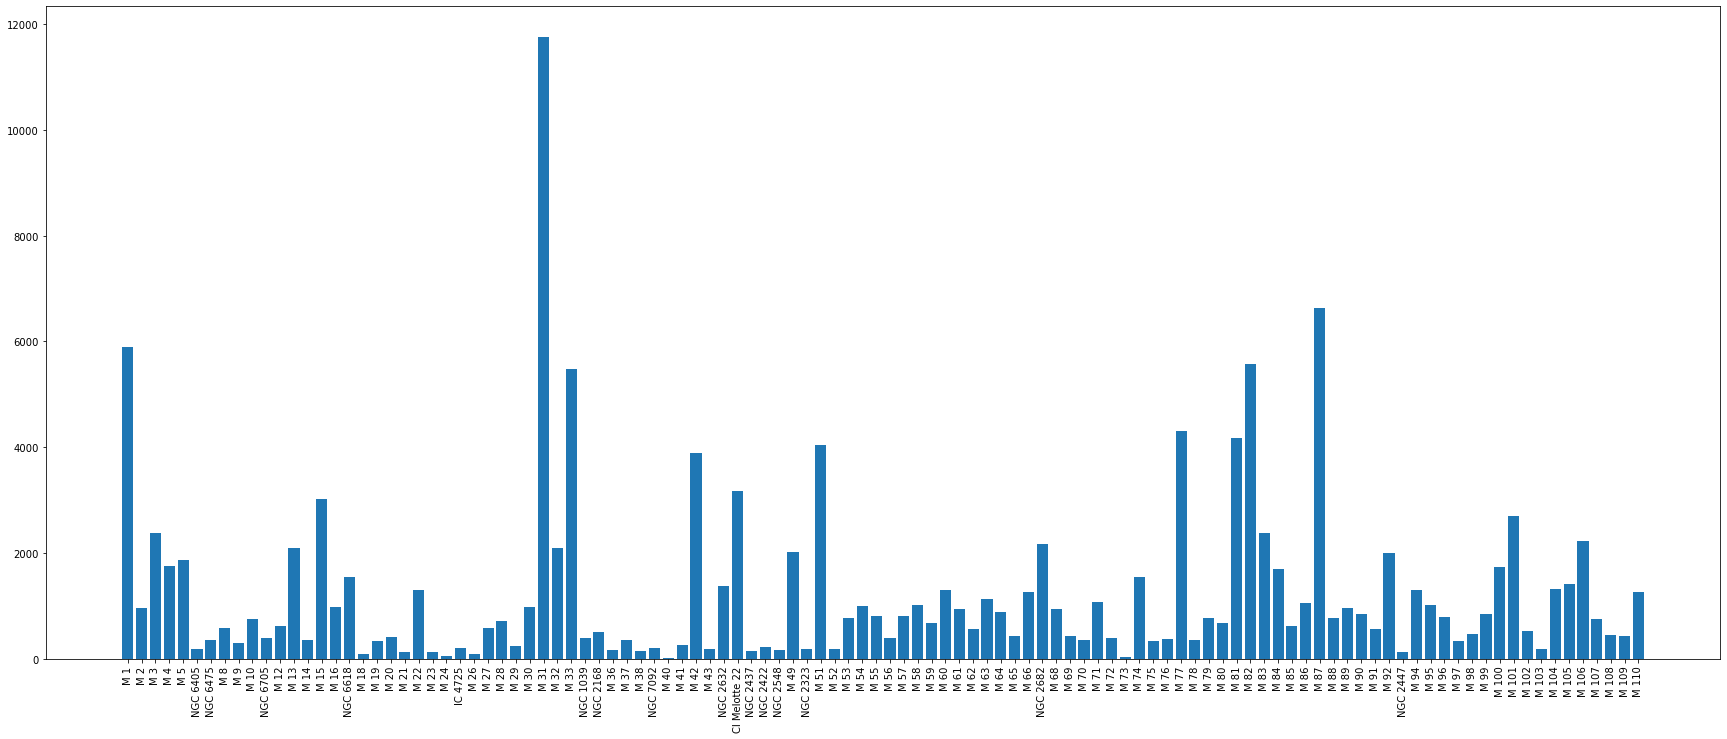

In [10]:
nombres = []
nArt = []

for o in objetos:
#    print(o)
    
    nombres.append(o['nombre'])
    nArt.append(o['nArticulos'])
    
import matplotlib.pyplot as plt  
plt.rcParams["figure.figsize"] = (30,12)
plt.xticks(rotation=90)
plt.bar(nombres, nArt)
plt.savefig("salidas/articulos.png")
plt.show()

**Gráfica de la evolución del número de artículos**

Esta gráfica muestra la evolución de los artículos en el tiempo para cada uno de los objetos del catálogo Messier:

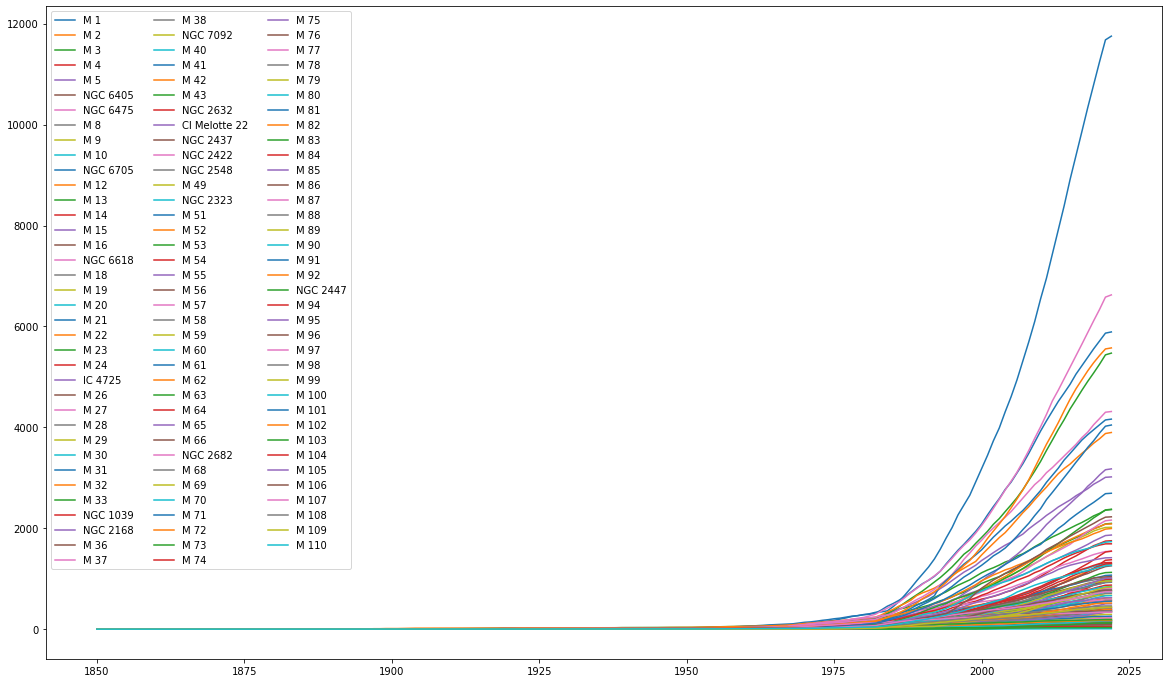

In [11]:
# Contamos cuantas referencias hay de un año en una lista de referencias de Simbad
def cuentaReferenciasAnio(anio, listaRefs):
    cuenta = 0
    
    for ref in listaRefs:
        if ref.startswith(str(anio)):
            cuenta += 1
            
    return cuenta

# Creamos una lista con los articulos que hay por anio en una lista de referencias
def listaNArticulosAntesDe(anios, listaRefs):
    resultado = []
    acumulado = 0
    
    for a in anios:
        acumulado += cuentaReferenciasAnio(a, listaRefs)
        resultado.append(acumulado)
        
    return resultado

anios = [a for a in range(1850, 2023)]

listaNArticulos = []

plt.rcParams["figure.figsize"] = (20,12)

for o in objetos:
    listaAcumulada = listaNArticulosAntesDe(anios,o['referencias'])
    
    plt.plot(anios, listaAcumulada, label=o['nombre'])


plt.legend(ncol=3)
plt.savefig("salidas/graficaPorAnio.png")
plt.show()